In [1]:
import os
data_dir = './datasets/jena_climate/'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

In [2]:
f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(f"header: \n{header}\n")
print(f"line length: {len(lines)}")

header: 
['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']

line length: 420451


In [3]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

In [4]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


In [5]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [6]:
import numpy as np
from tensorflow import keras

In [7]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [8]:
for samples, targets in train_dataset:
    print("sample shape:", samples.shape)
    print("target shape:", targets.shape)
    break

sample shape: (256, 120, 14)
target shape: (256,)


In [9]:
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt

- 순환 드롭아웃(recurrent dropout)

In [10]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/50
819/819 [==============================] - 50s 59ms/step - loss: 23.2295 - mae: 3.4423 - val_loss: 9.5520 - val_mae: 2.3975
Epoch 2/50
819/819 [==============================] - 52s 64ms/step - loss: 9.2911 - mae: 2.3766 - val_loss: 9.6678 - val_mae: 2.4201
Epoch 3/50
819/819 [==============================] - 51s 62ms/step - loss: 8.4694 - mae: 2.2667 - val_loss: 9.7652 - val_mae: 2.4129
Epoch 4/50
819/819 [==============================] - 52s 63ms/step - loss: 7.8609 - mae: 2.1839 - val_loss: 10.1337 - val_mae: 2.4620
Epoch 5/50
819/819 [==============================] - 51s 62ms/step - loss: 7.5125 - mae: 2.1321 - val_loss: 10.3277 - val_mae: 2.4975
Epoch 6/50
819/819 [==============================] - 51s 62ms/step - loss: 7.1820 - mae: 2.0831 - val_loss: 11.4069 - val_mae: 2.5767
Epoch 7/50
819/819 [==============================] - 50s 61ms/step - loss: 6.9048 - mae: 2.0392 - val_loss: 10.5954 - val_mae: 2.5279
Epoch 8/50
819/819 [==============================] - 51s

In [11]:
# inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
# #x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
# x = layers.LSTM(32)(inputs)
# x = layers.Dropout(0.5)(x)
# outputs = layers.Dense(1)(x)
# model = keras.Model(inputs, outputs)

# callbacks = [
#     keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
#                                     save_best_only=True)
# ]
# model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
# history = model.fit(train_dataset,
#                     epochs=50,
#                     validation_data=val_dataset,
#                     callbacks=callbacks)

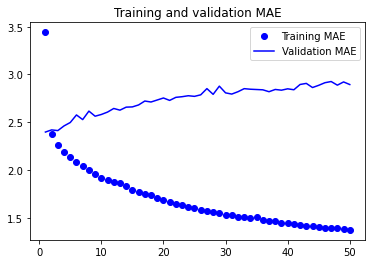

In [12]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()